# Ensemble Learning and Random Forests

집단지성과 유사하게 여러 예측기(분류기나 회귀기 등)의 예측을 집계하면  
개별 예측기 중 가장 성능이 좋은 것보다 더 나은 예측을 얻을 수 있음  
> 이러한 예측기의 그룹 -> **앙상블(Ensemble)**  
이를 사용하는 기법 -> 앙상블 학습(Ensemble Learning)  
앙상블 학습 알고리즘 -> **앙상블 방법(Ensemble method)**

예를 들어, 여러 개의 결정 트리 분류기를  
훈련 세트에서 무작위로 선택한 서로 다른 하위 집합에 대해 학습시킨 뒤  
각 트리의 예측을 모아 다수결로 최종 클래스를 예측할 수 있음  
이러한 결정 트리 앙상블을 **랜덤 포레스트(Random Forest)**라고 하며  
구현이 간단함에도 불구하고 매우 강력한 머신러닝 알고리즘 중 하나  

앙상블 방법은 보통 프로젝트 후반에 사용  
이미 몇 개의 좋은 예측기를 만들어 둔 뒤 이들을 결합해 더 나은 예측기를 생성할 때 사용  
실제로 머신러닝 대회에서의 우승 솔루션은  
여러 앙상블 방법을 조합해 사용하는 경우가 많음  
(대표적으로 Netflix Prize 대회)  

가장 널리 사용되는 앙상블 방법
- 배깅(Bagging)(+ 랜덤 포레스트)
- 부스팅(Boosting)
- 스태킹(Stacking)


## Setup

In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/0xInode/AI-study-notes/blob/main/ml/hands-on-ml/chapter07/chapter07.ipynb)


## Voting Classifiers

여러 분류기를 훈련시켰다고 가정  
각 분류기는 약 80%의 정확도  
(로지스틱 회귀 분류기, SVM 분류기, 랜덤 포레스트 분류기, K-최근접 이웃 분류기 등)

**간단한 방법: 하드 보팅 분류기**  
더 나은 분류기를 만드는 아주 간단한 방법 중 하나: 각 분류기의 예측을 집계하고, 가장 많은 표를 얻은 클래스를 예측하는 것  
이러한 다수결 기반의 분류기 -> 하드 보팅 분류기

이 보팅 분류기는 종종 앙상블 내에서 가장 좋은 분류기보다 더 높은 정확도를 보이는 경우가 있음  
각 분류기가 약한 학습자(무작위 추측보다 약간 더 나은 수준)라고 하더라도  
이들이 충분히 많고 서로 다양하다면  
앙상블 전체는 강한 학습자(높은 정확도)를 이룰 수 있음

왜 이런 일이 가능한가?
앞면이 나올 확률이 51%, 뒷면이 나올 확률이 49%인 동전을 1,000번 던진다고 가정  
보통은 약 510번 앞면, 490번 뒷면이 나와서 결국 앞면이 다수임  
수학적으로 계산해 보면, 1,000번 던졌을 때 앞면이 과반수 이상 나올 확률은 약 75%에 달함  
던지는 횟수를 늘리면 확률은 더 올라감(예: 10,000번이면 97% 이상)  
이것이 바로 대수의 법칙 때문  
반복 횟수가 많아질수록 실제 비율은 이론적 확률에 가까워짐  





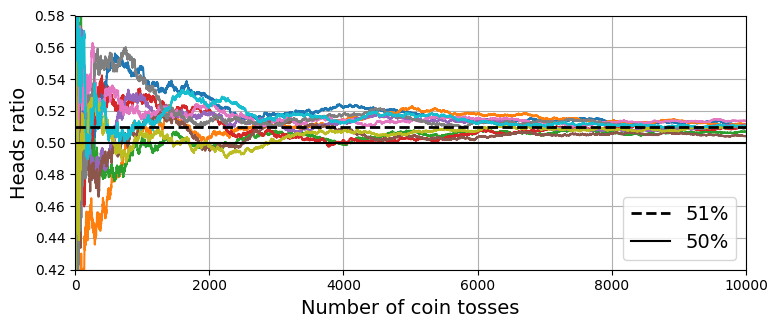

In [5]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)

# 10개의 동전을 10000번 던졌다고 가정해 앞면 여부를 0 또는 1로 생성
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)

# 누적 앞면 횟수 계산
cumulative_heads = coin_tosses.cumsum(axis=0)

# 누적 앞면 비율 계산
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))

# 동전 던지기 결과의 누적 앞면 비율 시각화
plt.plot(cumulative_heads_ratio)

# 이론적 확률 51%와 50% 기준선 표시
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")

plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()

# 대수의 법칙을 보여주는 그래프 저장
save_fig("law_of_large_numbers_plot")

plt.show()


이와 비슷하게 1,000개의 분류기로 이루어진 앙상블을 만든다고 가정  
각 분류기는 정확도가 51%임  
그러나 다수결로 예측하면, 정확도가 75%까지 올라갈 수 있음  
단, 모든 분류기가 **서로 완전히 독립적일 때만** 가능  
실제로는 동일한 데이터를 학습하기 때문에 비슷한 오류를 범할 가능성이 높고  잘못된 예측으로 다수결이 나올 수도 있음  
이런 경우 앙상블의 정확도는 떨어짐  

**핵심: 다양한 분류기**
앙상블 기법은 개별 모델들이 서로 독립적일수록 더 잘 작동함  
다양한 알고리즘을 사용해 분류기를 훈련시키면 서로 다른 종류의 오류를 범하게 되고, 앙상블의 정확도가 높아짐  

In [6]:
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# 반달 모양의 이진 분류 데이터셋 생성 (노이즈 포함)
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

# 학습용과 테스트용 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 세 가지 서로 다른 모델로 구성된 보팅 분류기 정의
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)

# 보팅 분류기 학습
voting_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [7]:
# 테스트 데이터 중 첫 번째 샘플에 대한 예측 수행
voting_clf.predict(X_test[:1])


array([1])

In [9]:
# 보팅에 참여한 개별 분류기들이 첫 번째 테스트 샘플에 대해 예측한 클래스 확인
[clf.predict(X_test[:1]) for clf in voting_clf.estimators_]


[array([1]), array([1]), array([0])]

In [10]:
# 보팅 분류기의 전체 테스트 세트에 대한 정확도 계산
voting_clf.score(X_test, y_test)


0.912

In [11]:
# 소프트 보팅으로 설정 (각 모델의 클래스 확률 평균 사용)
voting_clf.voting = "soft"

# SVC가 클래스 확률을 예측할 수 있도록 설정 (기본값은 비활성화)
voting_clf.named_estimators["svc"].probability = True

# 모델 재학습 (SVC 확률 활성화 후 fit)
voting_clf.fit(X_train, y_train)

# 소프트 보팅 기반 분류기의 정확도 평가
voting_clf.score(X_test, y_test)


0.92

## Bagging and Pasting

### Bagging and Pasting in Scikit-Learn

### Out-of-Bag Evaluation

## Random Patches and Random Subspaces

## Random Forests

### Extra-Trees

### Feature Importance

## Boosting

### AdaBoost

### Gradient Boosting

## Stacking